# Определение возраста покупателей

## Исследовательский анализ данных

### Импорт библиотек

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

### Загрузка данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


### Размер выборки

In [4]:
labels.shape

(7591, 2)

In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


### График распределения возраста в выборке

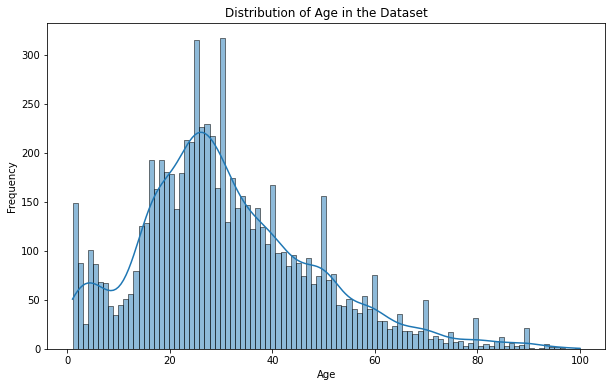

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=100, kde=True)
plt.title('Distribution of Age in the Dataset')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

### Выводим 15 фотографий

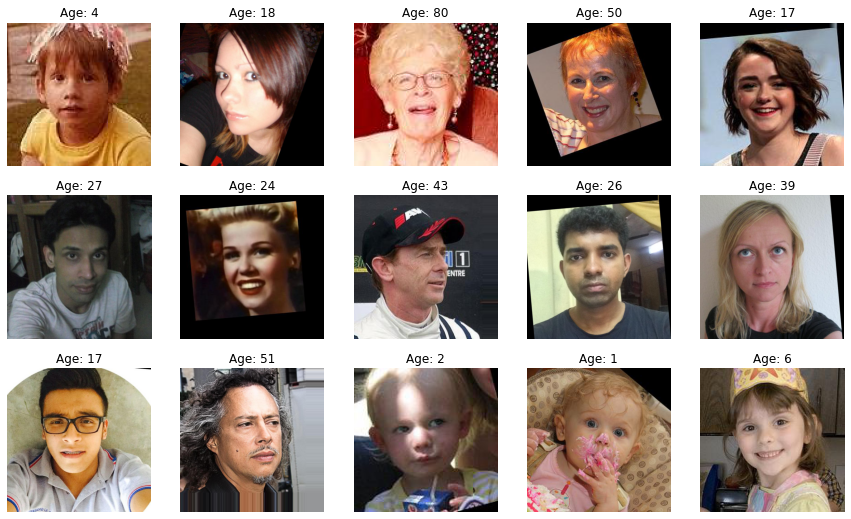

In [6]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for i, ax in enumerate(axes.flat):
    img_path = '/datasets/faces/final_files/' + labels['file_name'].iloc[i]
    img = Image.open(img_path)
    ax.imshow(np.array(img))
    ax.set_title(f"Age: {labels['real_age'].iloc[i]}")
    ax.axis('off')
plt.show()

### Вывод:

В выборке 7591 изображение. Представлены данные с двумя столбцами: имя файла и реальный возраст. Средний возраст в выборке составляет примерно 31 год, с минимальным возрастом в 1 год и максимальным в 100 лет. Медиана - 29 лет, то есть в датасете есть небольшое смещение в правую сторону. Распределение возраста неравномерное в некоторых областях, что может повлиять на качество обучения, если определенные возрастные группы представлены недостаточно. Например, больше всего изображений с возрастом примерно от 18 до 40. Возраст около 10 лет и после 60 - представлен в датасете в малом количестве.

Изображения нормализованы и имеют размер 224 x 224. Датасет выглядит хорошо структурированным и подготовленным для анализа возраста на основе изображений лиц. Возможные проблемы могут связаны с неравномерным распределением возраста, что требует дальнейшего исследования и возможной аугментации данных.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense,GlobalAveragePooling2D,  AvgPool2D, AveragePooling2D
from tensorflow.keras.models import Sequential
from keras import metrics
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    validation_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    
    val_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    
    return val_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library ...
I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties:
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
...
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
...
I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
...
I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-08-13 08:07:52.778340: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-13 08:07:53.249451: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 65s - loss: 235.1537 - mean_absolute_error: 11.0003 - val_loss: 769.4578 - val_mean_absolute_error: 22.8011
Epoch 2/10
178/178 - 49s - loss: 60.9160 - mean_absolute_error: 5.9234 - val_loss: 500.8708 - val_mean_absolute_error: 16.9686
Epoch 3/10
178/178 - 51s - loss: 29.0383 - mean_absolute_error: 4.1567 - val_loss: 263.4065 - val_mean_absolute_error: 11.9416
Epoch 4/10
178/178 - 55s - loss: 19.7731 - mean_absolute_error: 3.4359 - val_loss: 113.6051 - val_mean_absolute_error: 8.0902
Epoch 5/10
178/178 - 55s - loss: 16.5284 - mean_absolute_error: 3.1303 - val_loss: 78.6278 - val_mean_absolute_error: 6.6806
Epoch 6/10
178/178 - 54s - loss: 13.4799 - mean_absolute_error: 2.8122 - val_loss: 71.9077 - val_mean_absolute_error: 6.4041
Epoch 7/10
178/178 - 53s - loss: 10.4964 - mean_absolute_error: 2.4949 - val_loss: 66.9110 - val_mean_absolute_error: 6.1786
Epoch 8/10
178/178 - 52s - loss: 9.0360 - mean_absolute_error: 2.2810 - val_loss: 69.2182 - val_mean_absolute_error: 6.4753
Epoch 9/10
178/178 - 48s - loss: 8.0669 - mean_absolute_error: 2.1455 - val_loss: 64.9172 - val_mean_absolute_error: 6.0900
Epoch 10/10
178/178 - 39s - loss: 7.1535 - mean_absolute_error: 2.0227 - val_loss: 76.7134 - val_mean_absolute_error: 6.8453
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 76.7134 - mean_absolute_error: 6.8453
Test MAE: 6.8453


```

## Анализ обученной модели

Модель, основанная на архитектуре ResNet50, была обучена в течение 10 эпох. Наблюдалась стабильная убывающая тенденция в потерях как на тренировочном, так и на валидационном наборе данных. loss на тренировочном наборе уменьшился с 235 до 7, а средняя абсолютная ошибка с 11 до 2. По результатам валидации loss снизился до 77, а средняя абсолютная ошибка составила 6.8.

Эти результаты свидетельствуют о том, что модель обучилась предсказывать возраст с достаточной точностью, и MAE на валидационном наборе данных оказалась ниже 8. 

С точки зрения бизнеса модель может использоваться для анализа покупок в разных возрастных группах и для предложения товаров, которые могут заинтересовать покупателей конкретных возрастных категорий. Ошибка в 6.8 лет может быть приемлемой для разделения на более обобщенные группы, такие как дети, подростки, взрослые и пожилые. Возможность определения возраста также может использоваться для ограничения продажи алкоголя несовершеннолетним. Однако потребуется дополнительная проверка точности модели в диапазоне возрастов около законного возраста для покупки алкоголя.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы